# 📊 Salesforce MQL Sourcing Analysis

This project explores how marketing-qualified leads (MQLs) are sourced via Salesforce campaigns. It includes:

- A connection to Salesforce via `pandaforce`
- Basic data cleaning and normalization
- Exploration of campaign-level attribution

👉 Intended as a proof of concept for client-side automation and exploration.

> **Note:** All sensitive data has been anonymized or removed.

### 🔐 Connect to Salesforce

This cell logs into the Salesforce API using the `pandaforce` library (a Python wrapper around Salesforce's REST API.)

- The user is prompted for their **Salesforce password**.
- The username, organization ID, and security token should be manually added or inputted securely.
- Consider storing secrets in environment variables or a `.env` file for better security.

In [ ]:
from pandaforce import pandaforce as pf
import pandas as pd
import csv

# get credentials
pw = input("Enter your Salesforce password: ")

# Authenticate to Salesforce
sf=pf.login(username='YOUR_USERNAME_HERE', 
            password=pw, 
            orgid='YOUR_ORG_ID_HERE',
            securitytoken='INSERT_YOUR_SECURITY_TOKEN_HERE') # TODO: Secure this value later.

In [298]:
# First, get the full lead history for our Lead Status field. If this takes too long we can limit it.

# we can use Pandaforce to turn a SOQL query into a dataframe quite easily
leadStatusHist=sf.getdf("SELECT LeadId, Field, OldValue, NewValue, CreatedDate FROM LeadHistory WHERE Field='Status'")

In [299]:
# First, we group the statuses and counts.
# Then we rename the columns so they make a little more sense.
statusCounts=leadStatusHist.groupby(by="NewValue", as_index=False)['LeadId'].count()\
    .rename(columns={"NewValue": "Lead Status", "LeadId": "# leads"})
statusCounts # let's see what it shows us:

In [ ]:
mqlVals=['Assigned','MQL']
firstMQL=leadStatusHist[leadStatusHist['NewValue'].isin(mqlVals)]\
    .sort_values(by=['CreatedDate'])\
    .drop_duplicates(subset=['LeadId'], keep='first')\
    .rename(columns={"CreatedDate": "LeadUpdatedDate"})\
    .reset_index(drop=True) # this will make things tidier later
firstMQL.head() #Check and make sure things look as expected

### Example Output

This is a sample of what the cleaned MQL dataset looks like:

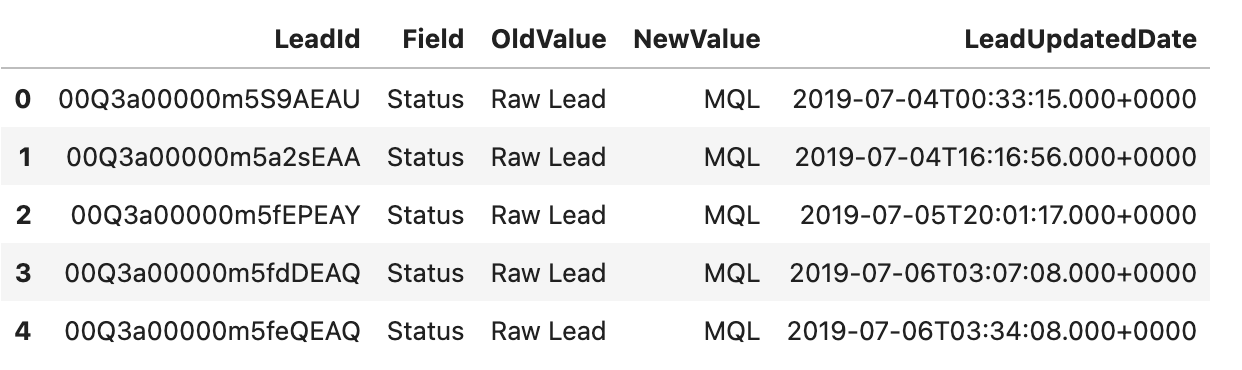

In [302]:
# First, get list of lead IDs
leads=firstMQL['LeadId'].tolist() 

# Then, pull all campaign  members from Salesforce to generate our campaign source data
campMembs=sf.getdf("SELECT id, LeadId, CampaignId, FirstRespondedDate FROM CampaignMember WHERE HasResponded=true")

# Now filter down to only campaign memberships for our leads we're working with
campMembs=campMembs[campMembs['LeadId'].isin(leads)].reset_index()

In [316]:
#  Get datetime formats set correctly
campMembs['FirstRespondedDate_UTC']=pd.to_datetime(campMembs['FirstRespondedDate'])\
    .dt.tz_localize('UTC')

firstMQL['LeadUpdatedDate_UTC']=pd.to_datetime(firstMQL['LeadUpdatedDate'])

In [317]:
results={} # create a dict which will store the campaign members that match the lead
leadswithnoCMs=[] # create aa list to store leads with no matching campaign members

for i in range(len(firstMQL)): # Looping through the first MQL table...
    thislead=firstMQL.iloc[i] # set 'thislead' to be the row we're working with
    mqlDate_UTC=thislead['LeadUpdatedDate_UTC'] # set MQL date with UTC timezone for calculation
    mqlDate=thislead['LeadUpdatedDate'] # I'm going to keep a regular date variable for the output though
    thisleadId=thislead['LeadId'] 
    
    # Now, filter down the CM dataframe to only this lead we're working with right now
    thisLeadCMs=campMembs[campMembs['LeadId']==thisleadId] #filter CMs to only this lead
    
    if not thisLeadCMs.empty: #if there are any campaign members for this lead...
        for c in range(len(thisLeadCMs)): #loop through them...
            thisCM=thisLeadCMs.iloc[c] # ...selecting one row at a time
            timeDiff=abs(thisCM['FirstRespondedDate_UTC']-mqlDate_UTC) # get the delta between the two UTC dates
            
            # Now add the 
            if timeDiff.days<1: # If they are within 24h of each other...
                values={'CampaignId': thisCM['CampaignId'],  # add the campaign id...
                        'CampaignFirstRespondedDate':thisCM['FirstRespondedDate'], # and the campaign response date
                        'LeadMQLDate': mqlDate  # and the MQL date (in its original format)
                       }
                results.update({thisleadId:values}) #  Now add these data to our results dictionary for later.
                
    
    else: # but if there are no campaign members for this lead...
        leadswithnoCMs.append(thisleadId) # ...we'll add those leadIDs to a separate list for later.

In [318]:
'''Take the results of the loop and reformat them'''

df=pd.DataFrame.from_dict(results,orient='index') #Take the campaign dictionary and make a dataframe from it
df.reset_index(level=0, inplace=True) #Reset the index so the lead ID gets its own column

# Now rename the former index col more clearly, order by responded date, and dedupe to only the first response
df=df.rename(columns={'index':'LeadId'})\
    .sort_values(by=['LeadId', 'CampaignFirstRespondedDate'])\
    .drop_duplicates(subset='LeadId', keep='first') #drop any duplicates

In [ ]:
'''Get lead and campaign data from Salesforce to join into this table '''

camps=sf.getdf("SELECT id, name, type FROM campaign")
leads=sf.getdf("SELECT id, name, company, title FROM lead")

# Adding prefixes makes everything way easier to read
camps=camps.add_prefix('Source_Campaign_')
leads=leads.add_prefix('Lead_')

# Now merge in the campaign and lead data into the table
campmerge=df.merge(camps,left_on='CampaignId',right_on='Source_Campaign_Id')\
    .drop(columns='Source_Campaign_Id')\
    .merge(leads,left_on='LeadId',right_on='Lead_Id')\
    .drop(columns='Lead_Id') #merge in lead data then drop the duplicate lead ID

# Reorganize the columns for legibility
cols=campmerge.columns.tolist()

def moveToFront(list, item): #Create function for reordering cols
    old_index = list.index(item) #Find old list position...
    list.insert(0,list.pop(old_index)) #...and move item to new list position
    
moveToFront(cols,'Lead_Title')
moveToFront(cols,'Lead_Company')
moveToFront(cols,'Lead_Name')
moveToFront(cols,'Source_Campaign_Type')
moveToFront(cols,'Source_Campaign_Name')

campmerge=campmerge[cols]\
    .sort_values(by=['Source_Campaign_Type','Source_Campaign_Name','Lead_Name'])\
    .reset_index(drop=True) # reset index and drop the existing index

#  Also let's add a summary table of the raw campaign data.
# This will count the unique leads
summary=campmerge.groupby(['Source_Campaign_Type','Source_Campaign_Name'], as_index=False)['LeadId'].count()\
    .rename(columns={"LeadId":"Number_of_MQLs"})

_Note: Data shown here is anonymized for privacy and confidentiality._

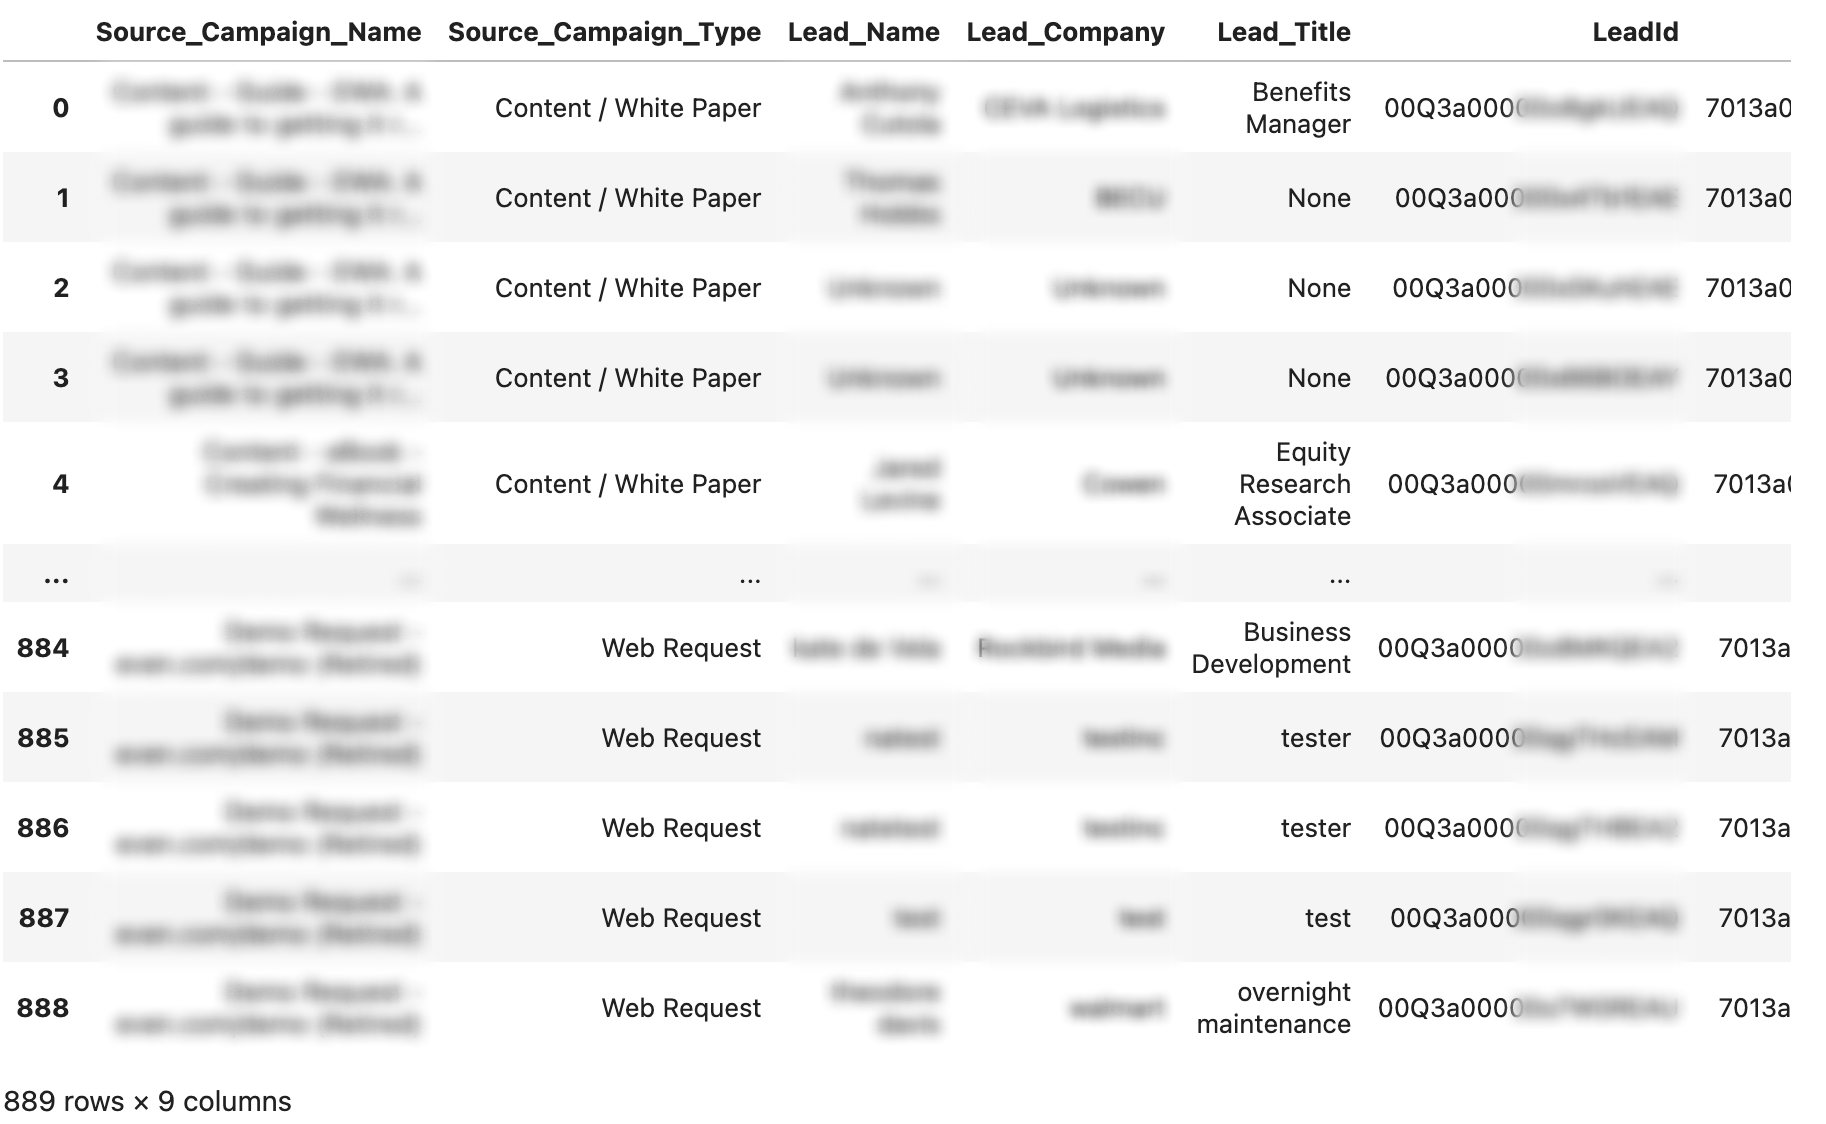

In [327]:
# Now to write the leads without sources to a table
# We return to our 'leadswithnoCMs' list of Lead IDs

leadswNoSource=pd.DataFrame(leadswithnoCMs, columns=['Lead_Id'])

# Now merge with the leads DF to get other lead fields
leadswNoSource=leadswNoSource.merge(leads, left_on='Lead_Id', right_on='Lead_Id')

# We will also merge back in the MQL date
mqlDateDF=firstMQL[['LeadId','LeadUpdatedDate']]
leadswNoSource=leadswNoSource.merge(mqlDateDF,left_on='Lead_Id',right_on='LeadId')\
    .drop(columns='LeadId')\
    .rename(columns={'LeadUpdatedDate':'MQL_Date'})

In [330]:
'''Write everything to ExcelWriter'''

filePath='/Users/martinbourqui/Downloads/MQLSources.xlsx'

with pd.ExcelWriter(filePath) as writer:  
    leadsWithSourcesTitle=str("All leads with source campaigns")
    campmerge.to_excel(writer, sheet_name=leadsWithSourcesTitle)
    
    summaryTitle=str("Campaign source summary totals")
    summary.to_excel(writer, sheet_name=summaryTitle)
    
    leadsWNoSourceTitle=str("MQLs w no matching camp. source")
    leadswNoSource.to_excel(writer, sheet_name=leadsWNoSourceTitle) 